# Mall Customer Segmentation
Mall Customer Segmentation is a data analysis project aimed at grouping customers based on similar characteristics and spending behaviors. The main objective of this project is to use clustering techniques to uncover distinct customer segments that exhibit comparable shopping habits and preferences.

This segmentation helps businesses better understand their customers, enabling personalized marketing strategies, improved customer service, and targeted promotions. By grouping customers into meaningful clusters, companies can allocate resources effectively and increase revenue through tailored product offers.

The project focuses on implementing two popular unsupervised clustering algorithms:

- K-Means Clustering, which partitions the customers into K predefined groups based on feature similarity, optimizing within-cluster variance.

- DBSCAN (Density-Based Spatial Clustering of Applications with Noise), which identifies clusters based on data density, effectively handling noise and non-spherical clusters without needing the number of clusters upfront.

## Importing Libraries

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

## Basic Observations

In [118]:
df = pd.read_csv('Mall_Customers.csv')

In [119]:
df.sample(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
199,200,Male,30,137,83
148,149,Female,34,78,22
165,166,Female,36,85,75
8,9,Male,64,19,3
145,146,Male,28,77,97
179,180,Male,35,93,90
128,129,Male,59,71,11
11,12,Female,35,19,99
84,85,Female,21,54,57
79,80,Female,49,54,42


The Mall Customer Segmentation dataset contains information about customers of a shopping mall, with the following key features:

- CustomerID: A unique identifier assigned to each customer for reference. This feature is used to distinguish records and is not directly used for clustering.

- Gender: The gender of the customer, typically categorized as Male or Female. This categorical feature can be encoded for analysis to explore differences in shopping behavior.

- Age: The age of the customer in years. Age is a continuous numerical feature and helps in understanding age-related shopping patterns.

- Annual Income (k$): The annual income of the customer in thousands of dollars. This numerical feature indicates the financial capability of the customer and is important for segmenting based on spending power.

- Spending Score (1-100): A score assigned by the mall which reflects customer spending behavior and loyalty. It is often calculated based on purchase history, frequency, and amount spent, with higher scores indicating more valuable customers.

In [120]:
df.shape

(200, 5)

In [121]:
df.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [122]:
duplicate_rows = df.duplicated().sum()
print(f'Number of duplicate rows: {duplicate_rows}')

Number of duplicate rows: 0


In [123]:
df.dtypes

,0
CustomerID,int64
Gender,object
Age,int64
Annual Income (k$),int64
Spending Score (1-100),int64


In [124]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


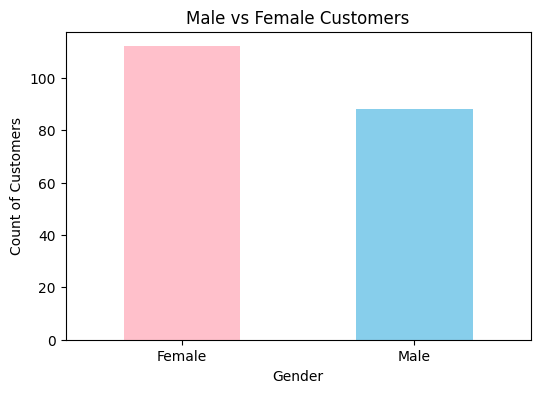

In [125]:
# Count the number of customers by Gender
gender_counts = df['Gender'].value_counts()

# Plot bar graph
plt.figure(figsize=(6,4))
gender_counts.plot(kind='bar', color=['pink','skyblue'])
plt.title('Male vs Female Customers')
plt.xlabel('Gender')
plt.ylabel('Count of Customers')
plt.xticks(rotation=0)
plt.show()

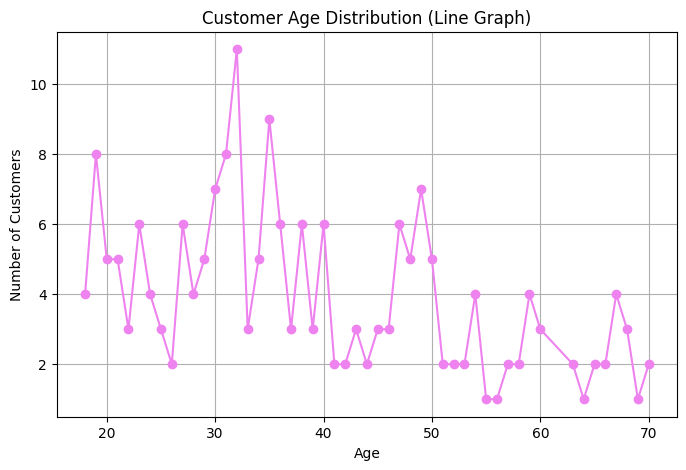

In [126]:
age_counts = df['Age'].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.plot(age_counts.index, age_counts.values, marker='o', linestyle='-', color='violet')
plt.title('Customer Age Distribution (Line Graph)')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.show()

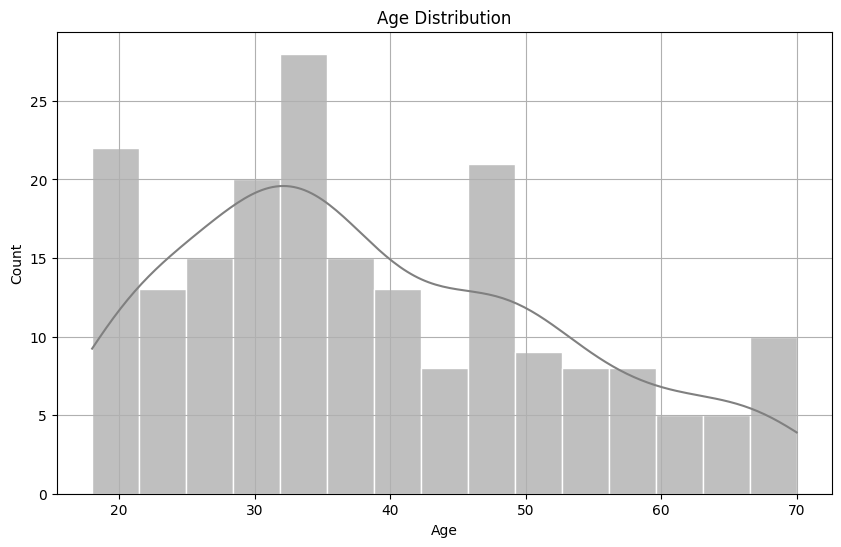

In [127]:
plt.figure(figsize=(10,6))
sns.histplot(df['Age'], bins=15, kde=True, color='grey', edgecolor='white')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True)
plt.show()

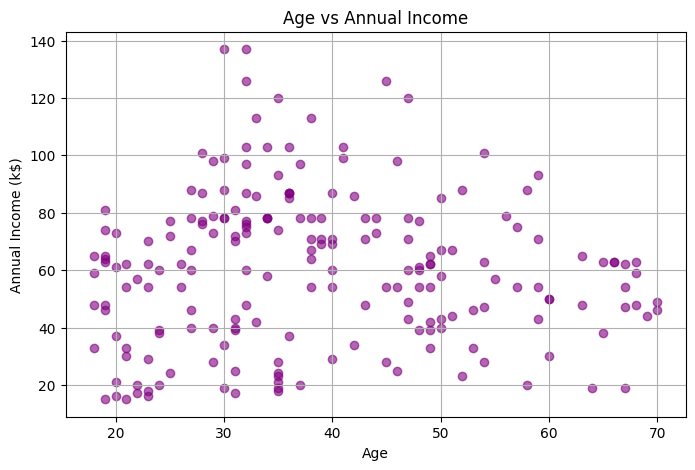

In [128]:
plt.figure(figsize=(8,5))
plt.scatter(df['Age'], df['Annual Income (k$)'], color='purple', alpha=0.6)
plt.title('Age vs Annual Income')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.grid(True)
plt.show()

This plot indicates that annual income among mall customers does not follow a simple trend with age; rather, customers of different ages can have varied incomes. There appear to be groups of customers within certain age ranges who share similar income levels, suggesting natural segments. Outliers are visible, showing that a few customers have substantially higher or lower incomes compared to others in their age group. This diversity highlights the importance of using clustering to discover meaningful customer segments for targeted marketing and business analysis.

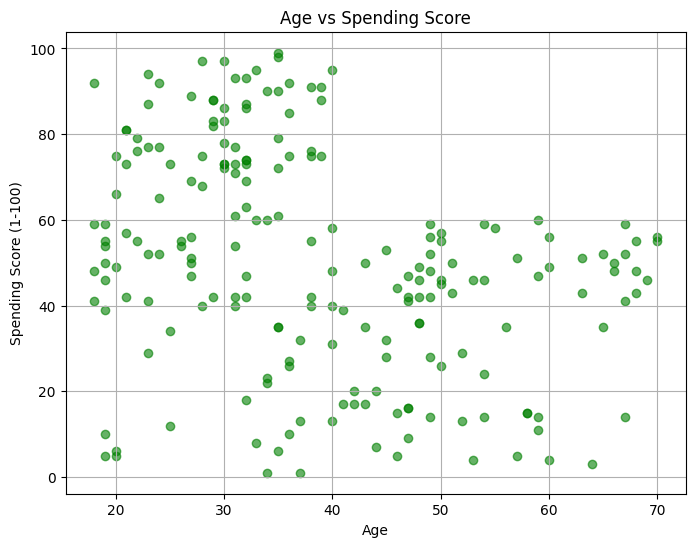

In [129]:
plt.figure(figsize=(8,6))
plt.scatter(df['Age'], df['Spending Score (1-100)'], alpha=0.6, color='green')
plt.title('Age vs Spending Score')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.grid(True)
plt.show()

This scatter plot displays the relationship between customer age and their spending score. Each point represents one customer in the mall dataset, with age on the x-axis and spending score on the y-axis.

- The data shows that high spending scores are more common among customers aged between 20 and 40, while both lower and mid-range spending scores are spread across all age groups.

- There is no clear linear pattern, indicating spending behavior does not consistently increase or decrease with age.

- Multiple groups or clusters are visually apparent—for example, young customers with high spending scores and older customers with more moderate or lower scores.

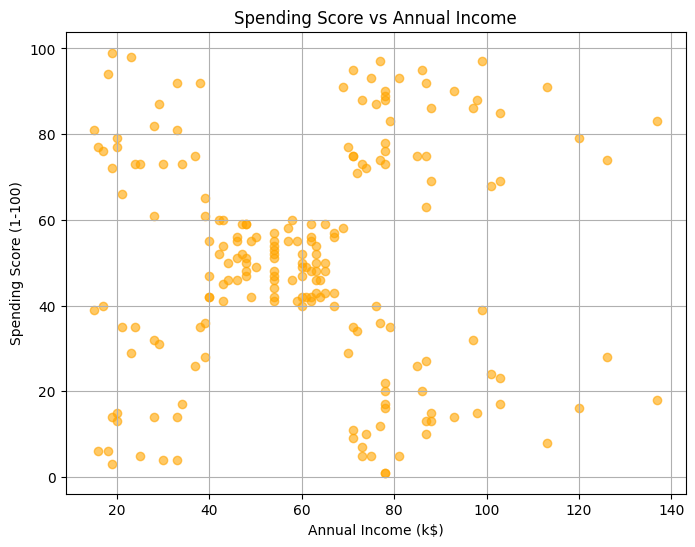

In [130]:
plt.figure(figsize=(8,6))
plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], alpha=0.6, color='orange')
plt.title('Spending Score vs Annual Income')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.grid(True)
plt.show()

## Data Preprocessing

### Dropping Unwanted Feature

In [131]:
df.drop('CustomerID', axis=1, inplace=True)

### Label Encoding Gender

In [132]:
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

Here 'Female' becomes 0, 'Male' becomes 1

### StandardScaler

Scaling is necessary in clustering because the algorithms use distance to group points, and if the features are not on similar scales, features with large numbers (like income) can dominate the clustering and hide patterns in the other features (like age or spending score). By scaling, all features contribute equally to the results, so the clusters that form reflect the real relationships in the data, not just the influence of one large-scale feature. This makes the clustering meaningful and fair for analysis, providing better insights into customer segments.

In [133]:
scaler = StandardScaler()
df[['Age', 'Annual Income', 'Spending Score']] = scaler.fit_transform(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
df.drop(['Annual Income (k$)', 'Spending Score (1-100)'], axis=1, inplace=True)

In [134]:
df.sample(10)

,Gender,Age,Annual Income,Spending Score
156,1,-0.132768,0.665675,-1.910021
37,0,-0.635135,-1.013780,0.885132
20,1,-0.276302,-1.395474,-0.590088
151,1,0.010765,0.665675,1.467455
162,1,-1.424569,0.780183,-1.754735
75,1,-0.922202,-0.250391,0.147522
130,1,0.584899,0.398489,-1.599448
184,0,0.154298,1.467233,-0.434801
19,0,-0.276302,-1.433644,1.855671
103,1,-0.922202,0.054964,0.186343


## K-Means clustering

K-Means is an unsupervised machine learning algorithm used to group data into K distinct clusters based on feature similarity.

**How it works:**

1. Choose the number of clusters, K.

2. Randomly initialize K centroids (one for each cluster).

3. Assign each data point to the nearest centroid using Euclidean distance.

4. Recalculate the centroids as the mean of all points in each cluster.

5. Repeat steps 3–4 until the centroids no longer change (convergence).

**Goal:**

Minimize the within-cluster sum of squares (WCSS) — meaning, make points within each cluster as close as possible to their centroid.

**Key points:**

- K must be chosen before training (often using the Elbow Method).

- Works best with numerical and scaled data.

- Sensitive to outliers and initial centroid placement.

### Select Features for Clustering

In [135]:
X = df[['Annual Income', 'Spending Score']]

### Use the Elbow Method to Find Optimal K


The elbow method helps you decide how many clusters are appropriate. It does this by plotting the inertia (sum of squared distances to the nearest cluster center) for different values of K. The 'elbow' point, where adding more clusters doesn't significantly improve inertia, is usually the best choice for K.

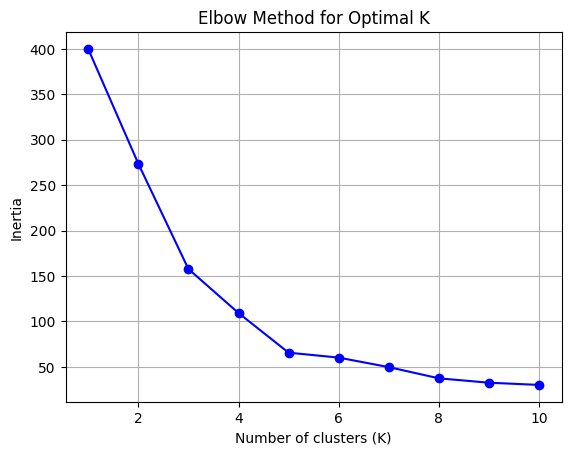

In [136]:
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

The elbow appears around K = 5, where the inertia drop flattens noticeably after a steep decline from K = 1 to 5; beyond 5, the improvement per added cluster is relatively small, suggesting diminishing returns. So a more defensible choice is K between 4 and 6, with 5 as the strongest candidate based on the curve shape.

In [137]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

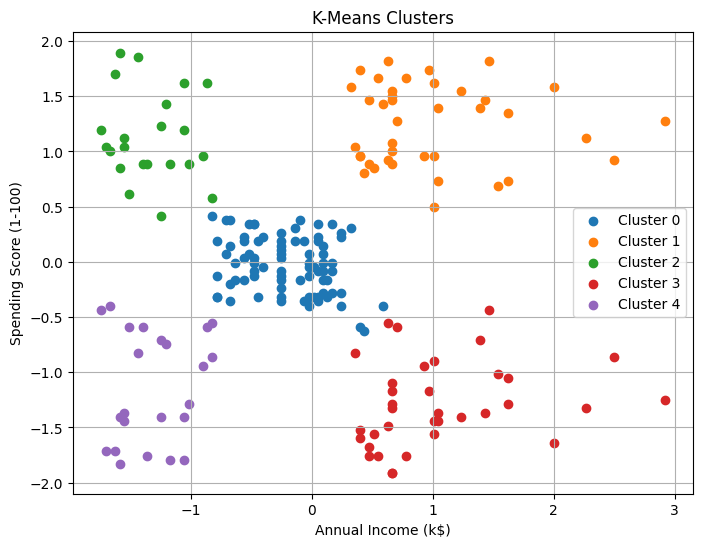

In [139]:
plt.figure(figsize=(8,6))
for cluster in range(5):
    plt.scatter(
        df.loc[df['Cluster'] == cluster, 'Annual Income'],
        df.loc[df['Cluster'] == cluster, 'Spending Score'],
        label=f'Cluster {cluster}'
    )
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('K-Means Clusters')
plt.legend()
plt.grid(True)
plt.show()

## DBSCAN clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is an unsupervised clustering algorithm that groups points based on data density, not predefined cluster counts.

**How it works:**

1. Define two parameters:

- ε (epsilon): maximum distance between two points to be considered neighbors.

- minPts: minimum number of points required to form a dense region.

2. For each point:

- If it has at least minPts neighbors within ε, it becomes a core point.

- Points within ε of a core point are reachable and belong to the same cluster.

- Points not reachable from any core point are labeled as noise (outliers).

3. The process continues until all points are assigned to a cluster or marked as noise.

**Key points:**

- No need to predefine the number of clusters.

- Can detect arbitrary-shaped clusters.

- Handles noise and outliers better than K-Means.

- Performance depends heavily on choosing suitable ε and minPts values.

In [141]:
X = df[['Annual Income', 'Spending Score']]

To determine the optimal values for eps and min_samples in DBSCAN:

- min_samples: A common rule is to set this to about the number of features plus one (so for two features, min_samples = 3 or a bit higher, often 4–5). More points per cluster increase required density and reduce tiny clusters, but too high can mark everything as noise.​

- eps (epsilon): Use a K-distance plot to select a value. For each point, calculate the distance to its k-th nearest neighbor (using min_samples), plot sorted values, and look for a sharp bend (elbow); the y-value at this point is a good choice for epsilon.

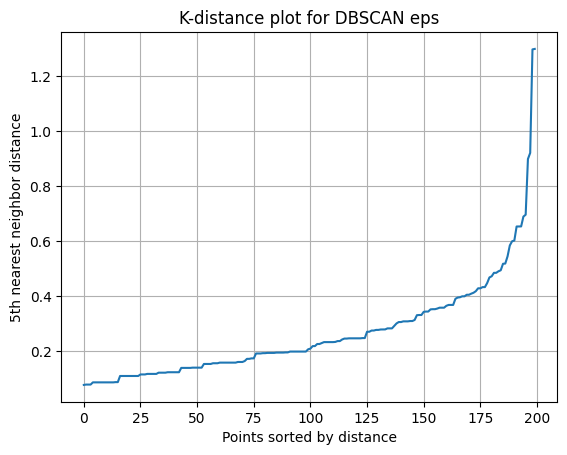

In [146]:
neighbors = NearestNeighbors(n_neighbors=5)  # k = min_samples
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances[:, 4])  # 4 for the 5th neighbor (0-based index)
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('5th nearest neighbor distance')
plt.title('K-distance plot for DBSCAN eps')
plt.grid(True)
plt.show()

On the x-axis are data points sorted by their distance to their 5th nearest neighbor, and the y-axis shows these distances. The plot rises gradually and then sharply increases to form an "elbow" or bend.

- The optimal eps is chosen near the point where this sharp bend begins, just before the steep rise.

- In your plot, that elbow appears around a y-value of 0.4 to 0.5.

- Setting eps around 0.4 or 0.5 should work well, as most data points within clusters are close, while values above this would start connecting points that are likely noise or outliers.

### Trying eps = 0.4

In [149]:
dbscan = DBSCAN(eps=0.4, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X)

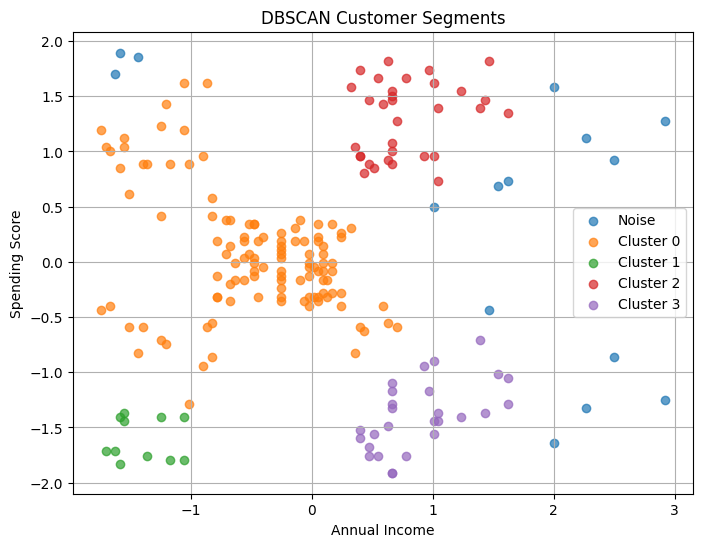

In [150]:
plt.figure(figsize=(8,6))
for cluster in sorted(df['DBSCAN_Cluster'].unique()):
    plt.scatter(
        df.loc[df['DBSCAN_Cluster'] == cluster, 'Annual Income'],
        df.loc[df['DBSCAN_Cluster'] == cluster, 'Spending Score'],
        label=f'Cluster {cluster}' if cluster != -1 else 'Noise',
        alpha=0.7
    )
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.title('DBSCAN Customer Segments')
plt.legend()
plt.grid(True)
plt.show()

### Trying eps = 0.5

In [160]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X)

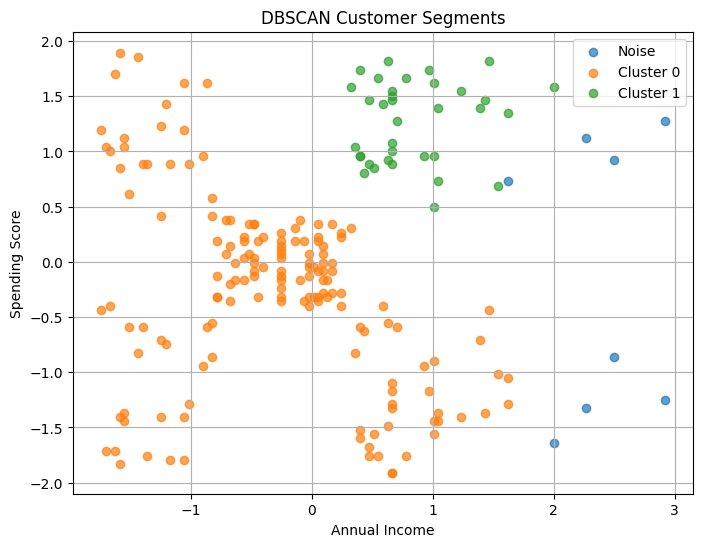

In [161]:
plt.figure(figsize=(8,6))
for cluster in sorted(df['DBSCAN_Cluster'].unique()):
    plt.scatter(
        df.loc[df['DBSCAN_Cluster'] == cluster, 'Annual Income'],
        df.loc[df['DBSCAN_Cluster'] == cluster, 'Spending Score'],
        label=f'Cluster {cluster}' if cluster != -1 else 'Noise',
        alpha=0.7
    )
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.title('DBSCAN Customer Segments')
plt.legend()
plt.grid(True)
plt.show()

Comparing both scatter plots, eps value of 0.4 seems to be more optimal than 0.5.